In [1]:
import numpy as np
import torch
import igl

import meshplot as mp
import sys as _sys
_sys.path.append("../src")
from elasticenergy import *
from elasticsolid import *
from adjoint_sensitivity import *
from vis_utils import *
from objectives import *
from harmonic_interpolator import *
from shape_optimizer import *

from utils import *

shadingOptions = {
    "flat":True,
    "wireframe":False,   
}

rot = np.array(
    [[1, 0, 0 ],
     [0, 0, 1],
     [0, -1, 0 ]]
)

torch.set_default_dtype(torch.float64)

# Create the deformed object

## Load the mesh

In [2]:
vNP, _, _, tNP, _, _ = igl.read_obj("../data/dinosaur.obj")
# vNP, _, _, tNP, _, _ = igl.read_obj("../data/beam.obj")

aabb = np.max(vNP, axis=0) - np.min(vNP, axis=0)
length_scale = np.mean(aabb)


v, t  = torch.tensor(vNP), torch.tensor(tNP)
eNP   = igl.edges(tNP)
beNP  = igl.edges(igl.boundary_facets(tNP))

bvNP, ivNP  = get_boundary_and_interior(v.shape[0], tNP)

mp.plot(vNP @ rot.T, np.array(tNP), shading=shadingOptions)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.987469…

## Add some physical characteristics

In [3]:
rho     = 131 # [kg.m-3], if aabb[0] ~ 14m, and m_tot = 6000kg
young   = 3e8 # [Pa] 
poisson = 0.2

# Find some of the lowest vertices and pin them
minZ    = torch.min(v[:, 2])
pin_idx = torch.arange(v.shape[0])[v[:, 2] < minZ + 0.01*aabb[2]]
vIdx  = np.arange(v.shape[0])
pin_idx  = vIdx[np.in1d(vIdx, bvNP) & np.in1d(vIdx, pin_idx)]
print("Pinned vertices: {}".format(pin_idx))

Pinned vertices: [ 46  47  50  59  60  62  64  65  88  89  91  98  99 102 103 104]


# Initial guess

The idea is that we start deforming the mesh by inverting gravity.

In [4]:
# Inverted gravity
force_mass = torch.zeros(size=(3,))
force_mass[2] = + rho * 9.81

# Gravity going in the wrong direction

ee = NeoHookeanElasticEnergy(young, poisson)

v = HarmonicInterpolator(v, t, ivNP).interpolate(v[bvNP])
solid_init = ElasticSolid(v, t, ee, rho=rho, pin_idx=pin_idx, f_mass=force_mass)

solid_init.find_equilibrium()
plot_torch_solid(solid_init, beNP, rot, length_scale)

# Use these as initial guesses
v_init_rest = solid_init.v_def.clone().detach()
v_init_def  = solid_init.v_rest.clone().detach()

# v_init_rest = solid_init.v_rest.clone().detach()
# v_init_def  = solid_init.v_def.clone().detach()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.468080…

# Inverse design


In [5]:
force_mass = torch.zeros(size=(3,))
force_mass[2] = - rho * 9.81
use_linear  = False

# The target is the initial raw mesh
vt_surf = torch.tensor(vNP[bvNP, :])

# Create solid
if use_linear:
    ee      = LinearElasticEnergy(young, poisson)
else:
    ee      = NeoHookeanElasticEnergy(young, poisson)
solid_      = ElasticSolid(v_init_rest, t, ee, rho=rho, pin_idx=pin_idx, f_mass=force_mass)
solid_.update_def_shape(v_init_def)

optimizer = ShapeOptimizer(solid_, vt_surf, weight_reg=0.)

v_eq_init    = optimizer.solid.v_def.clone().detach() #bookkeeping

Initial objective: 6.6351e+02



In [6]:
optimizer.optimize(step_size_init=1e-4, max_l_iter=10, n_optim_steps=40)

Objective after 19 optimization step(s): 5.8586e+02
    Line search Iters: 8
Elapsed time: 683.7s. 
Estimated remaining time: 755.7s



Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.497634…

An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
An exception occured: . 
Halving the step.
Line search can't find a step to take


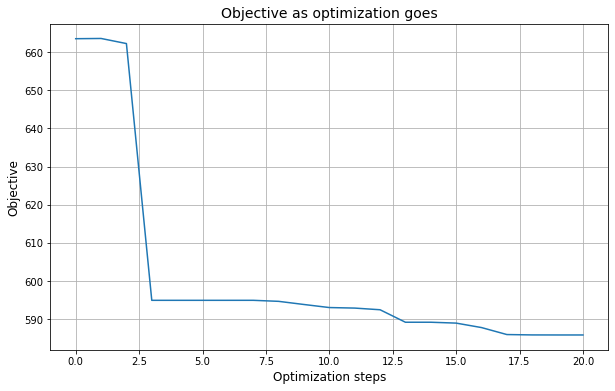

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(to_numpy(optimizer.objectives[optimizer.objectives > 0]))
plt.title("Objective as optimization goes", fontsize=14)
plt.xlabel("Optimization steps", fontsize=12)
plt.ylabel("Objective", fontsize=12)
plt.grid()
plt.show()

Green (Initial guess for rest state) deploys to Black

Blue (Optimized rest state) deploys to Yellow

Red is the Target Shape


In [8]:
p = mp.plot(np.array(optimizer.solid.v_def) @ rot.T, tNP, shading=shadingOptions)
# p.add_points(np.array(optimizer.solid.v_def)[pin_idx, :] @ rot.T, shading={"point_color":"black", "point_size": 0.2})
p.add_edges(np.array(v_init_rest) @ rot.T, beNP, shading={"line_color": "green"})
p.add_edges(vNP @ rot.T, beNP, shading={"line_color": "red"})
p.add_edges(np.array(v_eq_init) @ rot.T, beNP, shading={"line_color": "black"})
p.add_edges(np.array(optimizer.solid.v_rest) @ rot.T, beNP, shading={"line_color": "blue"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.497634…

4

In [9]:
v_rest_optim_g = optimizer.solid.v_rest.clone().detach() #bookkeeping

## Add point load to the right most vertices


In [ ]:
maxX        = torch.min(v[:, 0])
f_point_idx = torch.arange(v.shape[0])[v[:, 0] > maxX - 0.01*aabb[0]]

f_point = torch.zeros(size=(f_point_idx.shape[0], 3))
f_point[:, 2] = -5e3

optimizer.solid.add_point_load(f_point_idx, f_point)
optimizer.set_params(optimizer.params)
v_def_optim_g_under_point = optimizer.solid.v_def.clone().detach() #bookkeeping

In [ ]:
optimizer.reset_BFGS()
optimizer.optimize(step_size_init=1e-4, max_l_iter=10, n_optim_steps=20)

Green (Optimum rest state under gravity) deploys to Black with the additional point load

Blue (Optimized rest state) deploys to Yellow

Red is the Target Shape


In [ ]:
p = mp.plot(np.array(optimizer.solid.v_def) @ rot.T, tNP, shading=shadingOptions)
# p.add_points(np.array(optimizer.solid.v_def)[pin_idx, :] @ rot.T, shading={"point_color":"black", "point_size": 0.2})
p.add_edges(np.array(v_rest_optim_g) @ rot.T, beNP, shading={"line_color": "green"})
p.add_edges(vNP @ rot.T, beNP, shading={"line_color": "red"})
p.add_edges(np.array(v_def_optim_g_under_point) @ rot.T, beNP, shading={"line_color": "black"})
p.add_edges(np.array(optimizer.solid.v_rest) @ rot.T, beNP, shading={"line_color": "blue"})
